### *Poblématique :*
Quels indicateurs économiques ( Income, Expenditure, etc.) permettent de mieux discriminer les classifications économiques (Emerging, Developing) des pays ?

### 1. Importation des bibliothèques

In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder

### 2. Chargement et Préparation des Données

In [3]:
dataset = pd.read_csv('dataset_fin.csv')

In [4]:
from sklearn.preprocessing import StandardScaler

# Identification des variables explicatives et cible
X = dataset[[ 'Income', 'Expenditure ','Components of aggregate demand', 
             'Production', 'Households', 'Government',
             'Corporations', 'Capital']]
y = dataset['Economic_Classification']


In [5]:
X.head()

,Income,Expenditure,Components of aggregate demand,Production,Households,Government,Corporations,Capital
0,2.630387,6.318369,3.090439,3.665822,39871.843115,37.198877,2.826235,102.959793
1,0.676556,4.911191,2.438285,6.070283,40299.683652,53.010387,3.702775,102.748410
2,0.945041,3.635884,1.815193,4.515443,36499.838230,52.240785,5.092422,102.937581
3,5.478162,5.464745,2.960486,4.139944,34203.373443,41.238013,6.555331,103.696381
4,-1.181835,1.642339,1.019797,2.282649,16552.007381,27.749244,4.490536,103.703984


In [6]:
df = X.join(pd.Series(y, name='class'))

#### a.Calcul des moyennes des variables par classe

In [7]:
# Calcul des moyennes des features pour chaque classe
class_feature_means = pd.DataFrame(columns=y.unique())

# Sélectionner uniquement les colonnes numériques de X
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Grouper par classe (Economic_Classification) et calculer les moyennes
for c, rows in X.assign(target=y).groupby('target'):
    class_feature_means[c] = rows[numeric_cols].mean()


#### b.Calcul de la matrice de dispersion intra-classe

In [8]:
# Initialiser la matrice de dispersion intra-classes
num_features = X.shape[1]  # Nombre de variables explicatives
within_class_scatter_matrix = np.zeros((num_features, num_features))

# Calcul de la matrice de dispersion intra-classes
for c, rows in X.assign(target=y).groupby('target'):
    rows = rows.drop(['target'], axis=1)  # Retirer la colonne cible
    
    s = np.zeros((num_features, num_features))
    for index, row in rows.iterrows():
        x = row.values.reshape(num_features, 1)  # Transformer la ligne en vecteur colonne
        mc = class_feature_means[c].values.reshape(num_features, 1)  # Moyenne de la classe
        
        s += (x - mc).dot((x - mc).T)  # Calculer la contribution de la ligne
    
    within_class_scatter_matrix += s  # Ajouter la contribution de la classe


#### c. Calcul de la matrice de dispersion inter-classe

In [9]:
# Calcul des moyennes globales pour chaque feature
feature_means = X.mean()

# Initialiser la matrice de dispersion inter-classes
num_features = X.shape[1]  # Nombre de variables explicatives
between_class_scatter_matrix = np.zeros((num_features, num_features))

# Calculer la matrice de dispersion inter-classes
for c in class_feature_means.columns:  # Pour chaque classe
    # Taille de la classe
    n = len(y[y == c])
    
    # Moyenne de la classe et moyenne globale (reshaped en vecteurs colonnes)
    mc = class_feature_means[c].values.reshape(num_features, 1)  # Moyenne pour la classe c
    m = feature_means.values.reshape(num_features, 1)           # Moyenne globale
    
    # Mise à jour de la matrice de dispersion inter-classes
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

between_class_scatter_matrix


array([[ 3.1878e+02,  2.0515e+02,  1.0343e+02,  1.7917e+02,  2.2265e+05,
        -1.6592e+02, -4.0145e+01,  1.5394e+02],
       [ 2.0515e+02,  1.7728e+02,  8.6800e+01,  1.5156e+02,  1.2781e+05,
        -1.5448e+02, -3.0451e+01,  1.3638e+02],
       [ 1.0343e+02,  8.6800e+01,  4.2607e+01,  7.4343e+01,  6.5321e+04,
        -7.5163e+01, -1.5089e+01,  6.6632e+01],
       [ 1.7917e+02,  1.5156e+02,  7.4343e+01,  1.2974e+02,  1.1274e+05,
        -1.3147e+02, -2.6261e+01,  1.1641e+02],
       [ 2.2265e+05,  1.2781e+05,  6.5321e+04,  1.1274e+05,  1.6080e+08,
        -9.9572e+04, -2.6460e+04,  9.4752e+04],
       [-1.6592e+02, -1.5448e+02, -7.5163e+01, -1.3147e+02, -9.9572e+04,
         1.3664e+02,  2.5760e+01, -1.1945e+02],
       [-4.0145e+01, -3.0451e+01, -1.5089e+01, -2.6261e+01, -2.6460e+04,
         2.5760e+01,  5.5263e+00, -2.3192e+01],
       [ 1.5394e+02,  1.3638e+02,  6.6632e+01,  1.1641e+02,  9.4752e+04,
        -1.1945e+02, -2.3192e+01,  1.0511e+02]])

**Interprétation :**
* Les grandes valeurs sur la diagonale (par ex., 2.2265×10^5)     indiquent une forte variabilité pour la variable correspondante.
* Les petites valeurs ou valeurs proches de 0 indiquent une faible variabilité ou indépendance (dans le cas des covariances).
* Les valeurs négatives dans les éléments hors diagonale montrent une relation inverse entre les variables.


#### d. Calcul des valeurs propres et vecteurs propres

In [10]:
eigen_values, eigen_vectors = np.linalg.eig(
    np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix)
)


In [11]:
# Création des paires (valeur propre absolue, vecteur propre correspondant)
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))]

# Tri des paires par valeur propre absolue (ordre décroissant)
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

# Affichage des valeurs propres triées
for i, pair in enumerate(pairs):
    print(f"Valeur propre {i + 1}: {pair[0]}")


Valeur propre 1: 2.7839893875065687
Valeur propre 2: 0.11446352621793772
Valeur propre 3: 1.3682705261693708e-16
Valeur propre 4: 1.1646356905690034e-16
Valeur propre 5: 1.0428140702340248e-16
Valeur propre 6: 6.376181348545577e-17
Valeur propre 7: 6.376181348545577e-17
Valeur propre 8: 1.2387553810603815e-17


**Interprétation des valeurs propres :**
* Valeur propre 1 : 
  * 𝜆1=2.784 :
     Cette valeur est la plus élevée, ce qui indique que le premier axe discriminant (LD1) est celui qui explique le mieux la séparation entre les classes.
     Il capture la majorité de la variance inter-classes.
* Valeur propre 2 : 
  * 𝜆2=0.114 :
     Cette valeur est significativement plus petite que 𝜆1 , mais elle montre que le second axe discriminant (LD2) apporte encore une contribution mesurable à la discrimination des classes.
     La différence entre 𝜆1 et 𝜆2 souligne que l’essentiel de la séparation est contenu dans LD1.
* Valeurs proches de zéro (𝜆3 à 𝜆8) :
  Ces valeurs (par exemple, 1.37×10^−16 ) sont très faibles, indiquant que les axes associés (LD3 à LD8) n’apportent pratiquement aucune information utile à la discrimination.
  Ces axes peuvent être ignorés dans l’interprétation, car ils sont numériquement insignifiants.

#### e. Calcul de la variance expliquée

In [12]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {:.2%}'.format(i, (pair[0] / eigen_value_sums).real))


Explained Variance
Eigenvector 0: 96.05%
Eigenvector 1: 3.95%
Eigenvector 2: 0.00%
Eigenvector 3: 0.00%
Eigenvector 4: 0.00%
Eigenvector 5: 0.00%
Eigenvector 6: 0.00%
Eigenvector 7: 0.00%


**Interprétation :**
* Réduction de la dimensionnalité : 
   Les deux premiers axes (LD1 et LD2) suffisent pour capturer 100% de la variance inter-classes.
   Vous pouvez réduire l’espace discriminant à 2 dimensions (projection sur LD1 et LD2) sans perte significative d’information.
* Importance de LD1 :
  Avec 96.05% de variance expliquée, LD1 est l’axe principal. Il est responsable de la quasi-totalité de la séparation entre les classes.
* Rôle de LD2 :
  LD2 joue un rôle mineur mais non négligeable. Il peut révéler des distinctions subtiles entre des classes qui ne seraient pas visibles sur 
  LD1seul.
* Inutilité des autres axes (LD3 à LD8) :
  Ces axes n’apportent pas d’information supplémentaire utile à la discrimination des classes.
  Ils peuvent être ignorés dans l’interprétation ou visualisation des résultats.

In [13]:
# Créer la matrice W en empilant les deux premiers vecteurs propres (dimension 8x1)
w_matrix = np.hstack((pairs[0][1].reshape(8, 1), pairs[1][1].reshape(8, 1))).real

# Afficher la matrice W (composantes discriminantes)
print("Matrice W :")
print(w_matrix)


Matrice W :
[[ 1.5486e-01 -1.9108e-01]
 [-2.3907e-01  5.6070e-01]
 [ 6.1870e-01 -7.6031e-01]
 [ 6.9145e-01 -9.4492e-03]
 [ 1.4510e-06 -7.8183e-05]
 [-4.3215e-02  9.6832e-03]
 [ 6.3104e-02  1.6606e-01]
 [ 2.2830e-01  2.0804e-01]]


**Interprétation :**
* Colonne 1 (LD1) :

  Les coefficients de la première colonne montrent l’importance relative des variables explicatives dans la construction du premier axe discriminant (LD1), qui explique 96.05% de la variance inter-classes.

  * Variables ayant une contribution importante :
    * Variable 3 (0.6187)
    * Variable 4 (0.69145)
    * Ces deux variables jouent un rôle majeur dans la discrimination des classes sur LD1.

* Colonne 2 (LD2) :

  Les coefficients de la deuxième colonne montrent l’importance relative des variables explicatives dans la construction du second axe discriminant (LD2), qui explique 3.95% de la variance inter-classes.
  
  * Variables ayant une contribution importante :
    * Variable 3 (−0.76031)
    * Variable 2(0.5607)
    * Variable 8 (0.20804)
    Ces variables apportent des informations subtiles supplémentaires pour différencier les classes.


### Projection des données sur les axes discriminants

In [14]:
#Nouvelles...
X_lda = np.array(X.dot(w_matrix))

In [15]:
#Codage...
le = LabelEncoder()
y = le.fit_transform(df['class'])

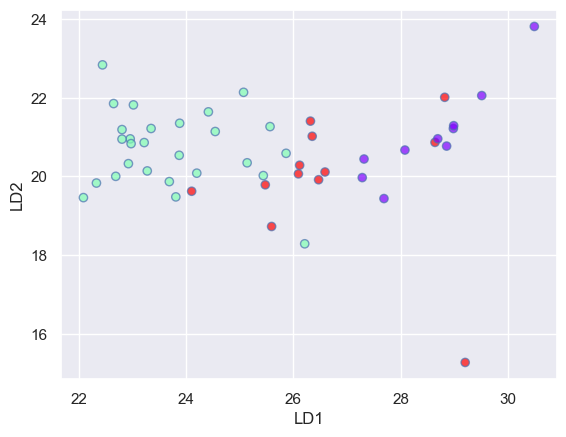

In [16]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()

Les deux axes LD1 (axe discriminant principal) et LD2 semblent offrir une bonne séparation entre les deux classes.
Les points en bleu et en rouge (probablement représentant différentes classes économiques) montrent un chevauchement modéré, mais LD1 semble discriminer davantage les classes.

les points de différentes classes se chevauchent, cela indique que les variables explicatives ne suffisent pas pour une discrimination claire.

### Application de l’AFD avec scikit-learn

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

In [18]:
#Variance expliquée par les axes
lda.explained_variance_ratio_

array([0.9605, 0.0395])

#### Visualisation des données projetées

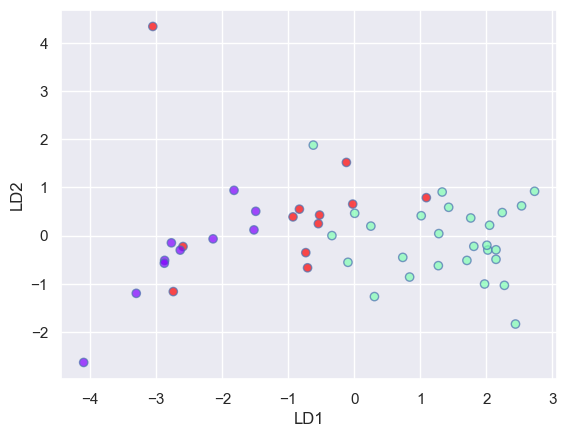

In [19]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()

Sur cette visualisation, la séparation entre les deux groupes (probablement les classes économiques "Emerging" et "Developing") est plus nette le long de l'axe LD1. Cela signifie que l'axe LD1 capte désormais les informations les plus discriminantes.
Les points bleus et rouges (classes distinctes) montrent moins de chevauchement par rapport au graphique précédent, ce qui témoigne d'une meilleure capacité discriminante après transformation.



* Les classes (différentes couleurs) sont désormais mieux séparées dans cet espace discriminant, surtout le long de LD1.
* Les points de la classe à droite (en cyan) sont clairement distincts des points des autres classes.
* Le graphique montre que les groupes peuvent être rangés dans des zones spécifiques de cet espace.
* Cela indique que l'AFD a permis d'identifier les directions où les groupes se distinguent le mieux.